In [1]:
import numpy as np 
import pandas as pd 
from load_and_summarize_data import *
from scipy.optimize import * 
import seaborn as sns
sns.set() 
%matplotlib inline

In [272]:
# Define tickers in consideration: 
tickers = ['ES=F', 'ZN=F','DX=F', 'GC=F']
labels  = ['S&P','10yr', 'Dollar', 'Gold']
mapping = dict(zip(tickers, labels))

# Load data for relevant tickers
data = Data(tickers=tickers, start_date='2011-01-02', end_date='2022-12-31')
data.rets.rename(columns=mapping, inplace=True)
data.rets.fillna(0)

[*********************100%***********************]  4 of 4 completed


,Dollar,S&P,Gold,10yr
Date,,,,
2011-01-03,0.000000,0.000000,0.000000,0.000000
2011-01-04,0.003968,0.000000,-0.031000,0.001170
2011-01-05,0.010527,0.005137,-0.003700,-0.008961
2011-01-06,0.006891,-0.001179,-0.001456,0.004849
2011-01-07,0.002812,-0.002165,-0.002115,0.007173
...,...,...,...,...
2022-12-23,-0.001124,0.005326,0.004980,-0.004128
2022-12-27,-0.001125,-0.003812,0.010524,-0.006633
2022-12-28,0.002782,-0.012322,-0.003802,-0.001252


In [273]:
# Compute a simple trend-following signal using a 21 - 260 day rolling mean 
windows = range(21, 260, 21)

# Define signal matrix
signals = np.empty(shape=(data.rets.shape[0], data.rets.shape[1], len(windows)))

# Loop through each window and compute a simple rolling average signal. Then take the sign
for w_idx, win in enumerate(windows):
    # Compute the rolling average
    roll_avg = data.rets.rolling(window=win, min_periods=round(win/2)).mean()
    signals[:,  :, w_idx] = np.sign(roll_avg)

# Take average across the windows and convert back to dataframe
signals = pd.DataFrame(np.nanmean(signals, axis=2))
signals.index   = data.rets.index 
signals.columns = data.rets.columns

# Weight each signal by the volatility of each market. Use smoothed returns
# to account for market-close times.
smoothed_rets = (np.log(1 + data.rets)).rolling(window=2).sum() / np.sqrt(2)
market_vols   = smoothed_rets.ewm(halflife=126, min_periods=21).std()
vol_adj_sigs  = signals / market_vols

# Compute the "volatility" of the combined signals
port_rets = (vol_adj_sigs.shift(1) * data.rets).sum(axis=1, skipna=False)
port_vols = np.abs(port_rets).ewm(halflife=126, min_periods=21).mean() * np.sqrt(np.pi / 2)
weights   = vol_adj_sigs.div(port_vols.shift(1), axis=0) * 0.1 / np.sqrt(252)

# Compute final returns based on the targeted weights
trend_rets = (weights.shift(1) * data.rets).sum(axis=1, skipna=False)
trend_vols = trend_rets.rolling(window=252, min_periods=126).std() * np.sqrt(252)

/var/folders/lk/0bw5f8_91g79kvbhsk_tqf9h0000gn/T/ipykernel_32338/759937378.py:14: RuntimeWarning: Mean of empty slice
  signals = pd.DataFrame(np.nanmean(signals, axis=2))


<AxesSubplot: xlabel='Date'>

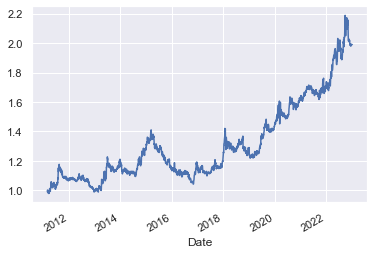

In [431]:
(1 + trend_rets).cumprod().plot()

<AxesSubplot: xlabel='Date'>

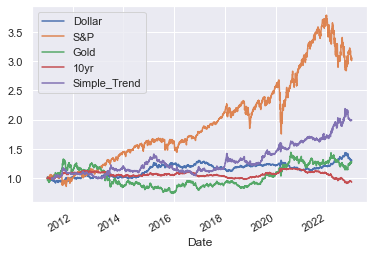

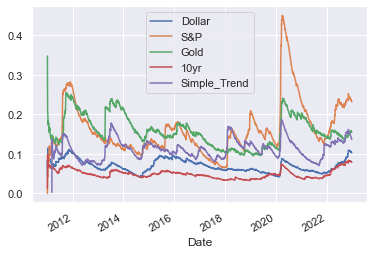

In [433]:
# Append to the list of all returns
data.rets['Simple_Trend'] = trend_rets

# Some quick plots
(1+data.rets).cumprod().plot()
(data.rets.ewm(halflife=63).std() * np.sqrt(252)).plot()


In [474]:
# Define functions used in a simple equal risk-contribution approach

# Compute portfolio variance
def compute_variance(weights, cov_mat):
    weights = np.array(weights)
    return weights.dot(cov_mat).dot(weights.T)

# Compute marginal risk contribution     
def compute_risk_contribution(weights, cov_mat):
    weights  = np.array(weights)
    port_var = compute_variance(weights, cov_mat)
    return (weights.dot(cov_mat) * weights) / port_var

# Define objective function to minimize variability of risk contribution
def objective_ERC(weights, args):
    # Get the marginal risk contributions of the guess
    risk_cont = compute_risk_contribution(weights, args[0])

    # Compute the variance of the risk contribution. Alternatively, we could 
    # do the sum of squared differences from a 1/n guess. 
    return np.var(risk_cont)

In [529]:
# Notional constraint 
def sum_to_one(weights):
    return np.sum(weights) - 1

# Add correlation constraint  
def max_correlation(weights, cov_mat, bench, corr_bound):

    # Compute the covariance between the portfolio and benchmark
    # (Coded the old-fashioned way for more practice)
    weights  = np.array(weights)
    one_hot  = np.zeros(shape=weights.shape)
    one_hot[bench] = 1
    port_cov = weights.dot(cov_mat).dot(one_hot)

    # Compute the vols of the portfolio and benchmark
    port_vol  = np.sqrt(weights.dot(cov_mat).dot(weights.T))
    bench_vol = np.sqrt(one_hot.dot(cov_mat).dot(one_hot.T))

    # Compute the correlation and return constraint 
    # -port_corr + corr_bound >= 0 
    # port_corr <= corr_bound
    port_corr = (port_cov) / (port_vol * bench_vol)
    return -port_corr + corr_bound

# Add bounds for non-negativity
num_factors = data.rets.shape[1]
bounds      = tuple((0, 1) for x in range(num_factors))

# Start out with an initial-guess of equal weights
guess = [1 / num_factors for x in range(num_factors)]

In [530]:
# Find beginning of each month to rebalance. Remove indexes with fewer than than 500 days.
rebal_idx = np.where(data.rets.index.is_month_start)[0]
rebal_idx = rebal_idx[rebal_idx > 501] 

In [561]:
# Create an empty set of weights
optim_wts  = pd.DataFrame().reindex_like(data.rets)
sp_col     = data.rets.columns.get_loc("S&P")
corr_bound = 0.25

# Loop through
for _, r_idx in enumerate(rebal_idx):
    # Get returns and compute simple covariance matrix
    rets_pd = data.rets.iloc[r_idx-500:r_idx, :]
    cov_mat = rets_pd.cov().to_numpy()

    # Define arguments 
    arguments = [cov_mat, sp_col, corr_bound]

    # Define constraints
    # constraints = ({"type": "eq", "fun": sum_to_one})
    constraints = ({"type": "eq", "fun": sum_to_one}, 
                   {"type":"ineq", "fun": max_correlation, "args": arguments})

    optim_res = minimize(objective_ERC, guess, args=arguments, method='SLSQP', bounds=bounds, constraints=constraints)
    optim_wts.iloc[r_idx, :] = optim_res.x

# Forward fill
optim_wts.fillna(inplace=True, method='ffill')
optim_wts = optim_wts.shift(1)

<AxesSubplot: xlabel='Date'>

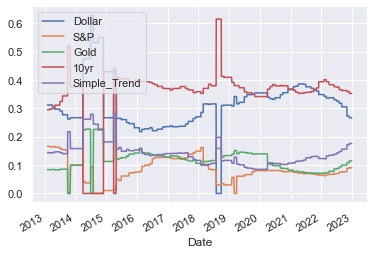

In [573]:
# Define the comparison period 
comp_idx = data.rets.index > data.rets.index[rebal_idx[0]]

# Plot weights 
optim_wts.loc[comp_idx, :].plot()

In [572]:
# Create comparison against equal-weights 
rets_erc  = (optim_wts * data.rets).sum(axis=1)
rets_ew   = (guess * data.rets).sum(axis=1)
rets_comp = pd.concat([rets_ew, rets_erc, data.rets.loc[:, 'S&P']],axis=1)
rets_comp.columns = ['Equal-weight', 'ERC-weight', 'S&P']
rets_comp = rets_comp.loc[comp_idx, :]

# Do correlation of weekly returns
rets_wk   = (1+rets_comp).groupby(pd.Grouper(freq='w')).prod() - 1
rets_wk.corr()

,Equal-weight,ERC-weight,S&P
Equal-weight,1.000000,0.776057,0.650118
ERC-weight,0.776057,1.000000,0.229559
S&P,0.650118,0.229559,1.000000


                AnnRet    AnnVol  SharpeRatio
Equal-weight  0.044849  0.052125     0.860405
ERC-weight    0.024287  0.035364     0.686787
S&P           0.082599  0.187897     0.439598


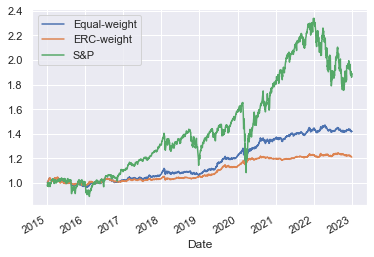

In [564]:
# Plot relative performance
plot_idx = rets_comp.index > '2015-01-02'
(1 + rets_comp.loc[plot_idx, :]).cumprod().plot()
print(compute_summary(rets_comp.loc[plot_idx, :]))

In [567]:
# Look at overall risk contribution 
wt_rets = optim_wts * data.rets
cov_wts = wt_rets.cov()
print((cov_wts.sum(axis=0) / cov_wts.values.sum()))

Dollar          0.249855
S&P             0.114495
Gold            0.204012
10yr            0.195085
Simple_Trend    0.236553
dtype: float64


In [568]:
compute_n_drawdowns(pd.DataFrame(rets_comp.iloc[:, 0]), num_dd=5)

,Drawdown,Peak Point,Trough Point,Recovery Point
0,-0.078205,2020-02-21,2020-03-18,2020-05-20 00:00:00
1,-0.073252,2015-04-10,2016-01-13,2017-02-21 00:00:00
2,-0.052599,2018-01-26,2018-12-24,2019-06-04 00:00:00
3,-0.039644,2022-04-19,2022-06-16,Ongoing
4,-0.033112,2020-09-01,2020-09-23,2021-01-04 00:00:00


In [569]:
compute_n_drawdowns(pd.DataFrame(rets_comp.iloc[:, 1]), num_dd=5)

,Drawdown,Peak Point,Trough Point,Recovery Point
0,-0.066286,2015-04-10,2015-12-30,2018-01-22 00:00:00
1,-0.035295,2013-05-17,2014-05-30,2014-09-04 00:00:00
2,-0.030523,2020-02-24,2020-03-16,2020-03-24 00:00:00
3,-0.027783,2018-01-26,2018-02-08,2019-01-02 00:00:00
4,-0.026030,2020-08-06,2021-03-04,2021-08-19 00:00:00
